# Homework 5 - Visit the Wikipedia hyperlinks graph!

-  Amirhossein Rajabi Shizari
-  Michael Aichmüller
-  Michele Cernigliaro


For this homework, all the tools are provided by the class *SnapGraph* in `Graph.py`

In [1]:
# importing the class
import Graph
# allocating new SnapGraph object
sg = Graph.SnapGraph()

## [RQ1] Build the graph $G=(V, E)$, where V is the set of articles and E the hyperlinks among them, and provide its basic information:

To answer this question, after we downloaded the data, we use the function *build_graph()*, which will provide:

+ all the nodes (removing unconnected nodes), stored in a numpy array
+ all the edges, stored into a pandas dataframe
+ all the categories, into a dictionary (key: Category_i, value: [list_of_articles])
+ node_degree of each article (number of edges incident to that article), stored into a dataframe
+ the graph: A dictionary of dictionaries, which contains:
    - keys : source articles
    - values: dictionaries with a list of keys (destination articles pointed by the source one). Each value of the destination article is one (since the graph is not weighted)
+ Plus, we created a 'reversed' graph. It has the same structure of the previous one with the only difference it referres to the destination articles. It will be used in the final part of the homework.

As requested, in our analysis we took into account all the categories that has a number of articles greater than 3500.

In [2]:
sg.build_graph()

Building graph: 100%|██████████| 2645247/2645247 [02:48<00:00, 15671.29it/s]


In [3]:
# nodes into a numpy array
sg.nodes

array([     52,      62,      64, ..., 1790187,  706468, 1790718])

In [4]:
# edges into a dataframe
sg.edges.head()

,v_start,v_end
0,52,401135
1,52,1069112
2,52,1163551
3,62,12162
4,62,167659


In [5]:
# a short representation of one category (first 10 articles)
sg.categories['English_footballers'][1:10]

[28411, 28961, 28979, 29264, 29573, 29582, 30896, 30900, 31902]

In [6]:
# node_degrees for each node
sg.node_degrees.head(3)

,0
52,3
62,9
64,1


#### a) Is the graph directed or not?
It's directed. To prove it it's sufficent pick two articles and see if they both have an edge which 'points' to the other one.

In [7]:
# picking the article '52'
sg.graph[52]

{401135: 1, 1069112: 1, 1163551: 1}

In [8]:
# picking the article 1069112
sg.graph[1069112]

{1060396: 1,
 1061304: 1,
 1062611: 1,
 1066969: 1,
 1069008: 1,
 1069113: 1,
 1069258: 1,
 1069275: 1,
 1656982: 1}

As we can see, we have only one edge from *52* to *1069112*, so the graph is directed.

#### b) The number of nodes, the number of edges and the average node degree

In [9]:
print('The number of nodes is: %d\n' %len(sg.nodes), 
      'The number of edges is: %d\n' %len(sg.edges), 
      'The average node degree is: %d' %sg.avg_node_degree, sep='')

The number of nodes is: 461193
The number of edges is: 2645247
The average node degree is: 6


#### c) Is the graph dense? 
The density for a directed graph is defined as follows: 

$$ \text{Graph_density} \triangleq \frac{\text{n_edges}}{\left|V\right|\cdot (\left|V\right|-1)} \ $$

With n_edges = number of edges and |V| = number of nodes.

Considering that the maximum number of edges in a directed graph is $n \cdot (n-1)$, we have the following:

In [10]:
n_edges = len(sg.edges)
n_nodes = len(sg.nodes)

print ('Graph_density is %f\n' % (n_edges/((n_nodes) * n_nodes-1)),
       'N_edges_max in a directed graph with %d nodes is: %d' %(n_edges, n_edges*(n_edges-1)), sep='')


Graph_density is 0.000012
N_edges_max in a directed graph with 2645247 nodes is: 6997329045762


The result is that the graph is not dense. This is normal, considering the amount of nodes that we have and the edges that we have cut with the recuced graph. But, since the average node degree is not so low (almost near 6), we have that each note is quite correlated in average with the others.

Since we have 461193 nodes (consider only correleted vertex), it's normal

## [RQ2]  a) Given a category $C_0 = \{article_1, article_2, \dots, article_3\}$ as input, build the block_ranking and sort the nodes in each category.


$$block_{RANKING} =\begin{bmatrix} C_0, \\ C_1, \\ \dots \\ C_c\\ \end{bmatrix}$$

For this task, we should compute the set of all the combination of shortest paths between the nodes of $C_0$ and $C_i$, with $i =\{1,\dots, c\}$. Then, for each category, we interprete the median as the distance.

Since we have a really high computation (we have to find pairwise distances between each article of $C_0$ with all the others nodes of the graph which don't belong to $C_0$), after we tried with *Dijkstra* algorithm, we decided to change our approach to the problem with the intention of reducing drastically the computation.

Hence, we decided to use the *bfs* algorithm (*Breadth-first search*). But, instead of computing the bfs for each node of $C_0$ with all the graph, we decided to interprete the distance from a node to $C_0$ as the **smallest distance from a vertex of $C_0$**. This means that, picking one node from another category, we assume its distance as the smallest shortest path to reach to $C_0$. The example in the image below may help the comprehension.

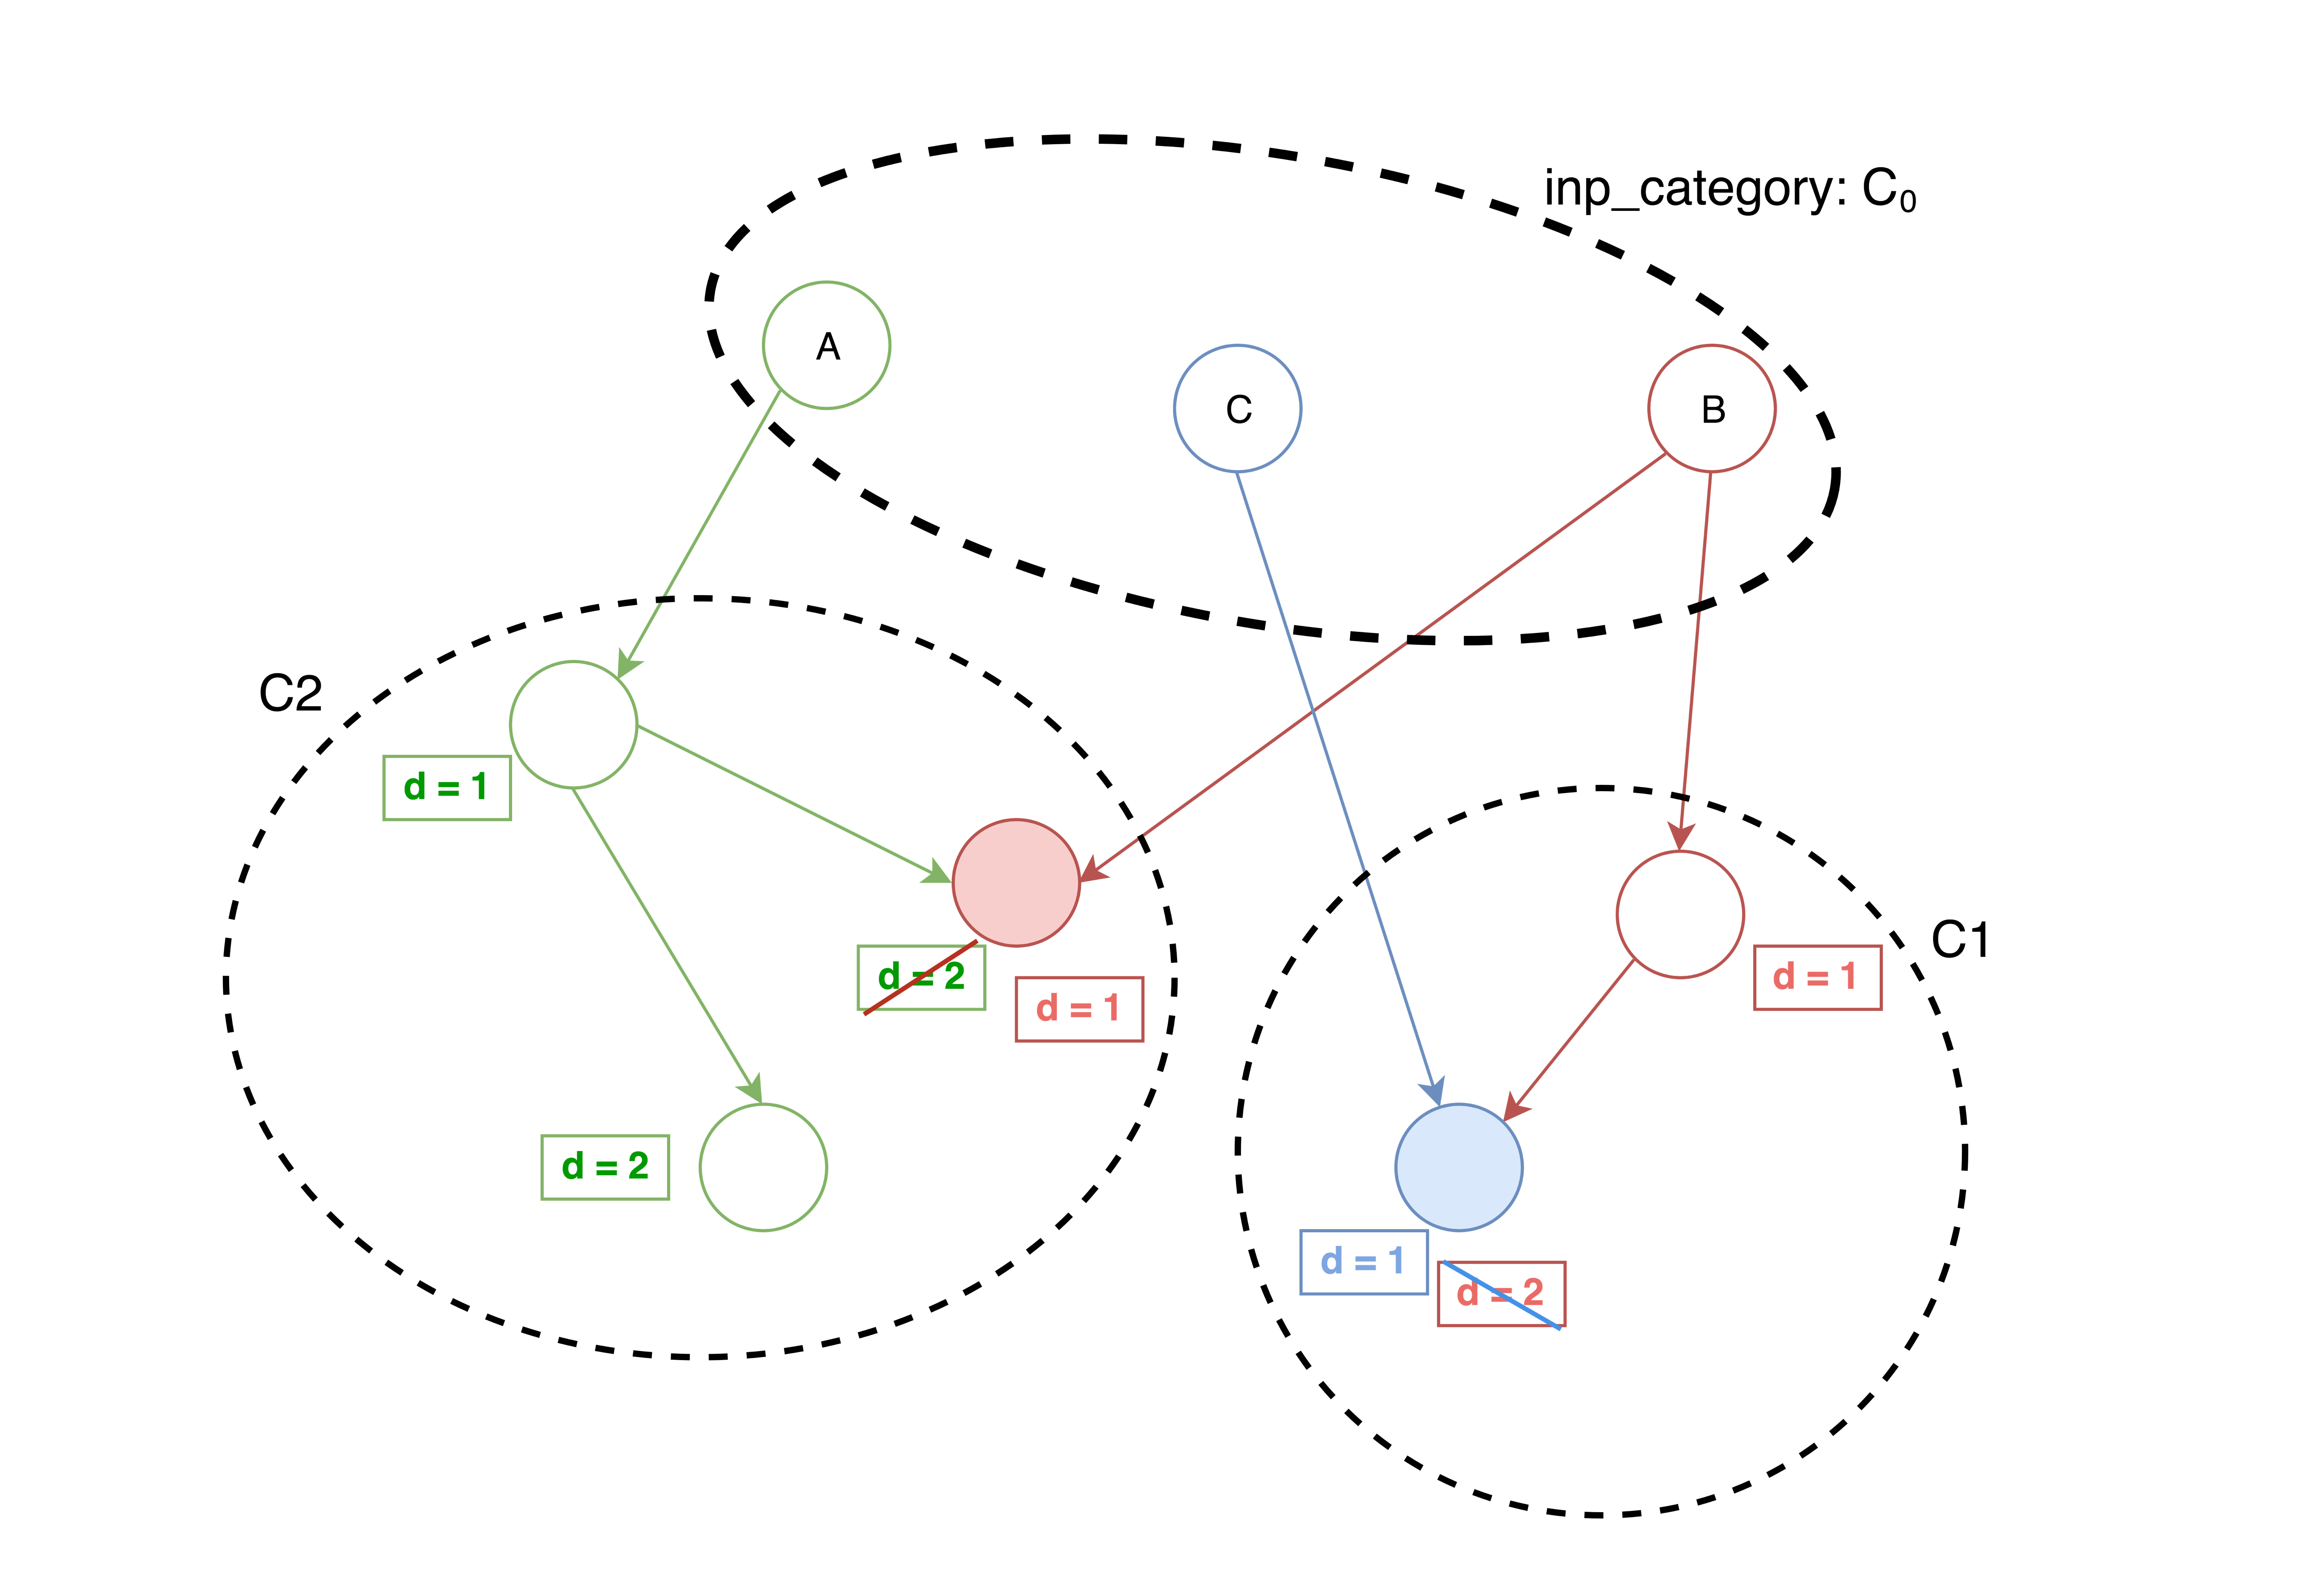

In [11]:
from IPython.display import Image
Image(filename='img/dg1.png')

We start considering the nodes not in $C_0$, assigning infinite to each one of them. We pick the first article A in the input category. From A, knowing that each edge has weight 1, we start assigning the distances. After that, we pick the second article in $C_0$, B. We start to move through the graph in the same way as we've done with A. The only main difference is that, if we find a shorter distance to move from B to a node, we assign that new distance to the node and its tree/subgraph that it follows.<br>
In other words, what we do is overwrite the path from each node of $C_0$ with another one, shorter, through the graph. This means that the more we use bfs with $C_0$ nodes, more faster will be the computation of shortest paths, since we're going to reduce more and more the breadth of research.

This algorithm is implemented with queue and dictionaries in the function SnapGraph._compute_distances(). Morover, this function is used by the function SnapGraph.block_rank_categories_bfs(), which implements the computation of the block_ranking (picking as score the **median** of all the shortest_paths from the nodes of the category $C_i$ to $C_0$). With this approach we exluded also the problem of infinites, since we cover all the connected nodes to the graph. Notice that we've excluded also shared nodes between $C_0$ and $C_i$'s, they would have 0 as distance.

The computation is really fast (expecially if compared with the normal *Dijkstra* algorithm) and the results, with 35 categories, seem to be quite accurate. Some results are shown below.

In [12]:
# block rank with C0 = English_footballers
block_rank = sg.block_rank_categories_bfs('English_footballers')
block_rank

Building block_ranking: 100%|██████████| 35/35 [03:23<00:00,  2.26s/it]


[('English_footballers', 0),
 ('The_Football_League_players', 1.0),
 ('Association_football_forwards', 5.0),
 ('Association_football_goalkeepers', 6.0),
 ('Association_football_midfielders', 7.0),
 ('Association_football_defenders', 7.0),
 ('English_cricketers', 8.0),
 ('Article_Feedback_Pilot', 12.0),
 ('English_television_actors', 17.0),
 ('British_films', 30.0),
 ('English-language_films', 33.0),
 ('American_Jews', 34.0),
 ('Members_of_the_United_Kingdom_Parliament_for_English_constituencies', 38.0),
 ('American_television_actors', 39.0),
 ('American_film_actors', 41.0),
 ('People_from_New_York_City', 46.0),
 ('Fellows_of_the_Royal_Society', 47.0),
 ('American_films', 51.0),
 ('American_military_personnel_of_World_War_II', 59.0),
 ('Living_people', 74.0),
 ('Harvard_University_alumni', 81.0),
 ('English-language_albums', 85.0),
 ('Place_of_birth_missing_(living_people)', 86.0),
 ('Major_League_Baseball_pitchers', 91.0),
 ('Black-and-white_films', 98.0),
 ('Debut_albums', 111.0),
 ('

In [13]:
# block rank with C0 = American_films
block_rank = sg.block_rank_categories_bfs('American_films')
block_rank

Building block_ranking: 100%|██████████| 35/35 [03:45<00:00,  2.45s/it]


[('American_films', 0),
 ('American_television_actors', 1.0),
 ('American_film_actors', 1.0),
 ('English_television_actors', 2.0),
 ('English-language_films', 2.0),
 ('People_from_New_York_City', 2.0),
 ('Black-and-white_films', 2.0),
 ('British_films', 3.0),
 ('American_Jews', 3.0),
 ('Article_Feedback_Pilot', 3.0),
 ('American_military_personnel_of_World_War_II', 5.0),
 ('English-language_albums', 8.0),
 ('Place_of_birth_missing_(living_people)', 9.0),
 ('Harvard_University_alumni', 11.0),
 ('Debut_albums', 11.0),
 ('Windows_games', 11.0),
 ('Year_of_birth_missing_(living_people)', 12.0),
 ('Indian_films', 13.0),
 ('Living_people', 15.0),
 ('Fellows_of_the_Royal_Society', 17.0),
 ('Major_League_Baseball_pitchers', 19.0),
 ('Year_of_birth_missing', 21.0),
 ('Year_of_birth_unknown', 22.0),
 ('Members_of_the_United_Kingdom_Parliament_for_English_constituencies', 24.0),
 ('Year_of_death_missing', 24.0),
 ('English_footballers', 30.0),
 ('The_Football_League_players', 30.0),
 ('English_cr

In [14]:
# block rank with C0 = Rivers_of_Romania
block_rank = sg.block_rank_categories_bfs('Rivers_of_Romania')
block_rank

Building block_ranking: 100%|██████████| 35/35 [03:38<00:00,  1.70s/it]


[('Rivers_of_Romania', 0),
 ('Article_Feedback_Pilot', 949.0),
 ('English_television_actors', 1852.0),
 ('English-language_films', 2027.0),
 ('British_films', 2269.0),
 ('American_Jews', 2377.0),
 ('Association_football_midfielders', 2787.0),
 ('Association_football_forwards', 2893.0),
 ('American_television_actors', 3040.0),
 ('American_film_actors', 3119.5),
 ('American_films', 3316.0),
 ('Association_football_defenders', 3382.0),
 ('People_from_New_York_City', 3720.0),
 ('Association_football_goalkeepers', 4161.0),
 ('The_Football_League_players', 4187.0),
 ('English_footballers', 4318.0),
 ('American_military_personnel_of_World_War_II', 6311.0),
 ('Harvard_University_alumni', 6844.5),
 ('Fellows_of_the_Royal_Society', 7173.0),
 ('Black-and-white_films', 7820.0),
 ('Major_League_Baseball_pitchers', 7828.0),
 ('Members_of_the_United_Kingdom_Parliament_for_English_constituencies',
  8334.0),
 ('Living_people', 10711.0),
 ('Place_of_birth_missing_(living_people)', 11164.5),
 ('English-

**Notice** that in our class SnapGraph, we have also implemented the block_ranking **using pairwise distance** (each node of $C_0$ with all the other nodes). It computes the distances according to *dijkstra* algorithm. The function which performs it is SnapGraph.block_rank_category(). 

### b) Obtained the block_ranking, sort the nodes of each category.

We want to sort the article in each category, at the end we will have a 'new' rank_score with also the list of nodes and their score:

$$\text{ranking_nodes_sorted} = \begin{bmatrix} C_0, [\text{sorted_nodes of } C_0] \\ C_1, [\text{sorted_nodes of } C_1] \\ \dots \\ C_c , [\text{sorted_nodes of } C_0]\\ \end{bmatrix}$$

The score of each article is given according to the formula:

$$ score_{article_i} = \sum_{j \in in-edges(article_i)} w_j $$

with $w_j$ sum of the weight of in-edges for article j

To implement this new vector, we've used pandas dataframe properties, and we build a pandas series that will be attached to each category in the block_ranking. This series will have as index the article and as values its score

In [15]:
block_rank = sg.block_rank_categories_bfs('American_films')
sorted_cat = sg.sort_categories_nodes(block_rank)

Sorting categories nodes: 100%|██████████| 35/35 [01:21<00:00,  2.10s/it]


In [16]:
# slice of the first 3 categories (C0 included)
sorted_cat[0:3]

[('American_films', 0, v_end
  1058236    97336
  1065379    86247
  1061299    61206
  1061229    60552
  1253687    36125
  1061298    23716
  1063315    15745
  1060953    14884
  1062362    13456
  1062354    12100
  1063218     8450
  1061246     7497
  1058575     5832
  1065496     5408
  1061113     5292
  1061245     4658
  1061214     4536
  1061346     4107
  1063279     3888
  1059346     3844
  1063020     3698
  1063898     3640
  1058683     3614
  1060548     3600
  1061126     3564
  184609      3528
  1061268     3450
  1061017     3249
  1062755     3249
  1061227     3230
             ...  
  1265313        1
  1265301        1
  1265300        1
  1265265        1
  1265192        1
  1265132        1
  1264965        1
  1054632        1
  1054371        1
  1054360        1
  1054049        1
  1265717        1
  1054050        1
  1054092        1
  1054104        1
  1054122        1
  1054123        1
  1054124        1
  1054129        1
  1054153        1
  

In [17]:
# looking into the first category after C_0
sorted_cat[1]

('American_television_actors', 1.0, v_end
 1060651    2165130000
 1062938      72000000
 1166281      58778538
 1174957      30402800
 1061752      30291138
 1062622      16381944
 1061774      15777533
 1062121      12030520
 1174955       7717500
 1061950       7610324
 1039495       6854640
 1062195       6570180
 1163590       6438696
 1062037       5616000
 1061463       4366656
 1061900       2267708
 1061381       2248384
 1061937       2218752
 1060442       1913625
 1061744       1656828
 1059445       1654104
 1061783       1622025
 1061449       1607824
 1061969       1577384
 1061724       1504476
 1163217       1468800
 1061813       1306449
 1061772       1081344
 1062008        963300
 1062507        944906
               ...    
 812916              1
 1028808             1
 501296              1
 1130498             1
 1161168             1
 1190865             1
 1190878             1
 1190888             1
 1165275             1
 1190971             1
 501445        

In [18]:
# looking into the last one
sorted_cat[-1]

('Rivers_of_Romania', 829.0, v_end
 786913    278
 786295    151
 786474    140
 784802     84
 785977     73
 783990     71
 785974     60
 786832     57
 786269     56
 785970     54
 785978     53
 786137     53
 787049     52
 785107     46
 785992     46
 786018     44
 787142     43
 786773     39
 786111     39
 784442     39
 786833     38
 783659     37
 783641     37
 785205     36
 787189     35
 784684     34
 786513     34
 784194     33
 784253     33
 785021     33
          ... 
 787531      1
 787532      1
 787534      1
 787535      1
 787503      1
 787502      1
 787500      1
 787497      1
 787458      1
 787460      1
 787461      1
 787462      1
 787463      1
 787469      1
 787470      1
 787472      1
 787473      1
 787474      1
 787475      1
 787479      1
 787480      1
 787481      1
 787483      1
 787486      1
 787491      1
 787492      1
 787493      1
 787494      1
 787496      1
 72111       1
 Name: score, Length: 7659, dtype: int64)